## 174 - Adding METARS

[Youtube](https://www.youtube.com/watch?v=1HBiw4b06zg)

In [69]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.plots as mpplots
from siphon.catalog import TDSCatalog
import numpy as np
import metpy
#
from io import StringIO, BytesIO
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from matplotlib.patheffects import withStroke
from metpy.cbook import get_test_data
import pandas as pd

In [36]:
dt = datetime(2022, 9, 10) - timedelta(days = 2)

### RTMA

In [70]:
rtma_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xtml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray = True)
rtma_data = rtma_data.metpy.parse_cf()
rtma_data

<xarray.Dataset>
Dimensions:                                                              (
                                                                          time6Offset: 1,
                                                                          : 2,
                                                                          reftime9: 717,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          ...
                                                                          time14Offset: 1,
                                                                          reftime4: 716,
                                                                          time9Offset: 1,
                                                                          reftime11: 716,
                                                                          time5Offset: 1,
                                                                          altitude_above_msl: 1)
Coordinates: (12/51)
  * time6Offset                                                          (time6Offset) float64 ...
  * reftime9                                                             (reftime9) datetime64[ns] ...
    time6                                                                (reftime9, time6Offset) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * reftime3                                                             (reftime3) datetime64[ns] ...
    ...                                                                   ...
  * time9Offset                                                          (time9Offset) float64 ...
    time9                                                                (reftime4, time9Offset) datetime64[ns] ...
  * reftime11                                                            (reftime11) datetime64[ns] ...
  * time5Offset                                                          (time5Offset) float64 ...
    time5                                                                (reftime11, time5Offset) datetime64[ns] ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
Dimensions without coordinates: 
Data variables: (12/23)
    LambertConformal_Projection                                          int32 ...
    time6Offset_bounds                                                   (time6Offset, ) datetime64[ns] ...
    time6_bounds                                                         (reftime9, time6Offset, ) datetime64[ns] ...
    Total_cloud_cover_Analysis_entire_atmosphere_single_layer            (reftime3, time13Offset, y, x) float32 ...
    Pressure_error_surface                                               (reftime, time12Offset, y, x) float32 ...
    Wind_direction_from_which_blowing_error_height_above_ground          (reftime1, time8Offset, height_above_ground, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_Analysis_height_above_ground                              (reftime12, time2Offset, height_above_ground, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (reftime4, time9Offset, height_above_ground, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (reftime11, time5Offset, height_above_ground, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (reftime6, time7Offset, y, x) float32 ...
    Dewpoint_temperature_Analysis_height_above_ground                    (reftime8, time14Offset, height_above_ground1, y, x) float32 ...
    Total_precipitation_Forecast_altitude_abov

In [71]:
pres = rtma_data['Pressure_Analysis_surface'].metpy.sel(reftime8 = dt, method = 'nearest').squeeze()
temp = rtma_data['Temperature_Analysis_height_above_ground'].metpy.sel(reftime9 = dt, method = 'nearest').squeeze()
dewp = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].metpy.sel(reftime = dt, method = 'nearest').squeeze()

KeyError: 'reftime8'

In [23]:
temp

<xarray.DataArray 'Temperature_Analysis_height_above_ground' (y: 1377, x: 2145)>
[2953665 values with dtype=float32]
Coordinates:
  * x                     (x) float32 -2.763e+06 -2.761e+06 ... 2.682e+06
  * y                     (y) float32 -2.638e+05 -2.612e+05 ... 3.231e+06
    metpy_crs             object Projection: lambert_conformal_conic
    height_above_ground1  float32 2.0
    reftime9              datetime64[ns] 2022-09-08
    time10Offset          float64 0.0
    time10                datetime64[ns] 2022-09-08
Attributes:
    long_name:                       Temperature Analysis @ Specified height ...
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LambertConformal_Projection
    Grib_Variable_Id:                VAR_7-4--1-0_L103
    Grib2_Parameter:                 [0 0 0]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                103
    Grib2_Level_Desc:                Specified height level above ground
    Grib2_Generating_Process_Type:   Analysis
    Grib2_Statistical_Process_Type:  UnknownStatType--1

In [62]:
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)
theta_e = mpcalc.smooth_gaussian(theta_e, n = 8)
plot_proj = theta_e.metpy.cartopy_crs

### METAR

In [25]:
airports_df = pd.read_csv(get_test_data('airport-codes.csv'))
airports_df.head()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A
1,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK
2,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL
3,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,00AR,NaN,00AR
4,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ


In [66]:
airports_df = airports_df[(airports_df['type'] == 'large_airport') | (airports_df['type'] == 'medium_airport')]
airports_df.head()

metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

metar_file = metar_cat.datasets.filter_time_nearest(dt).remote_open()

metar_text = StringIO(metar_file.read().decode('ascii','ignore'))

sfc_data = parse_metar_file(metar_text, year = dt.year, month = dt.month)

sfc_units = sfc_data.units

sfc_units

sfc_data = sfc_data[sfc_data['station_id'].isin(airports_df['ident'])]

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

sfc_data['u'], sfc_data['v'] = mpcalc.wind_components(sfc_data['wind_speed'], sfc_data['wind_direction'])

locs = plot_proj.transform_points(ccrs.PlateCarree(), sfc_data['longitude'].m, sfc_data['latitude'].m)

sfc_data_mask = mpcalc.reduce_point_density(locs[:, :2], 125000)

### Plot

Text(0.5, 1.0, '2022-09-08 00Z')

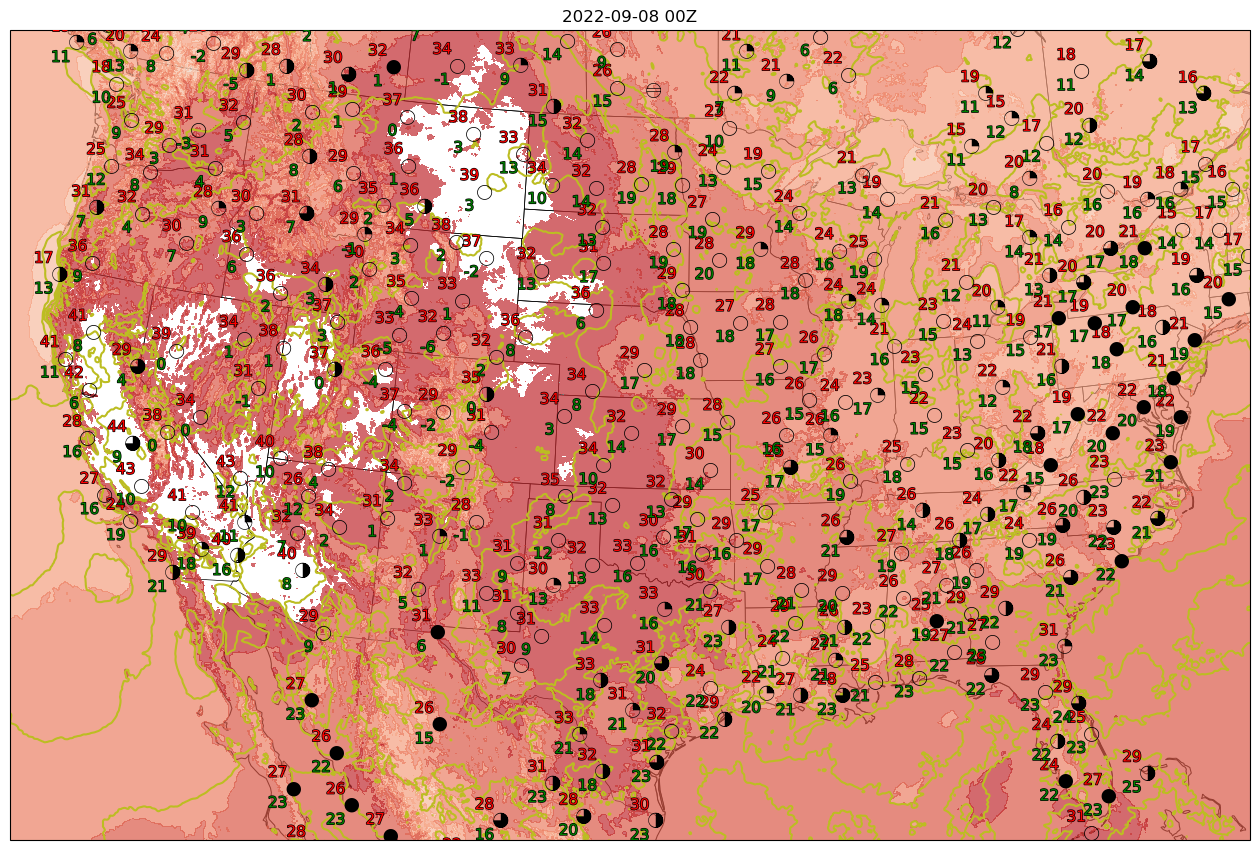

In [68]:
fig = plt.figure(figsize = (18, 14))
ax = fig.add_subplot(1, 1, 1, projection = plot_proj)
ax.set_extent((-122, -75, 25, 50), crs = ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

ax.contourf(temp.metpy.x, temp.metpy.y, temp - 273.15, transform = temp.metpy.cartopy_crs, levels = np.arange(-30, 40, 5), cmap = 'coolwarm', alpha = 0.7)
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform = theta_e.metpy.cartopy_crs, levels = np.arange(240, 400, 10), colors = 'tab:olive')

# METAR
stn = mpplots.StationPlot(ax, sfc_data['longitude'][sfc_data_mask].m, sfc_data['latitude'][sfc_data_mask].m, transform = ccrs.PlateCarree(), fontsize = 11, zorder = 10, clip_on = True)
stn.plot_parameter('NW', sfc_data['air_temperature'][sfc_data_mask], color = 'red', path_effects = [withStroke(linewidth = 1, foreground = 'black')])
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][sfc_data_mask], color = 'green', path_effects = [withStroke(linewidth = 1, foreground = 'black')])
stn.plot_symbol('C', sfc_data['cloud_coverage'][sfc_data_mask], mpplots.sky_cover)
stn.plot_barb(sfc_data['u'][sfc_data_mask], sfc_data['v'][sfc_data_mask])


plt.title(dt.strftime('%Y-%m-%d %HZ'))